In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import fnmatch 
from tqdm import tqdm 
import fnmatch 
import torch 
import pandas as pd 

In [2]:
#def moving_average(x, w):
#    return np.convolve(x, np.ones(w), 'valid') / w

def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

In [3]:
from utils import save_dir, analyze_dir, results_dir
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
analyze_identifier= 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'

In [4]:
# load accuracy data first 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

hier_accu=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:07, 146.39it/s]


In [5]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches

In [6]:
# load mftma files 
data_=pickle.load(open(os.path.join(analyze_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_mftma_pooled_v3_nrep_250.pkl'), 'rb'))
mftma_res=data_['mftma_results']
#if not os.path.exists(os.path.join(result_dir,analyze_identifier,model_identifier)):
#        os.makedirs(os.path.join(result_dir,analyze_identifier,model_identifier))
temp=[np.asarray([x['seq'] for x in mftma_res[y]]) for y in mftma_res.keys()]
y=temp[0]
for k in temp:
    y=np.intersect1d(y,k)

In [8]:
mftma_epochs=[np.asarray([x['epoch'] for x in mftma_res[y]]) for y in mftma_res.keys()]
mftma_batch=[np.asarray([x['batch'] for x in mftma_res[y]]) for y in mftma_res.keys()]


In [9]:
l_num=1
layer_data=mftma_res['layer_1_Linear']
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_correspondance=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

In [13]:
layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
corrected_data=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_correspondance):
    corrected_data[int(x)]=layer_cap[idx,:]

In [14]:
x_bar= np.arange(len(batches))/len(batches)
epoch_bar=np.argwhere(np.diff(epochs))/(len(batches))
np.ceil(epoch_bar*10)/10

array([[0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5],
       [0.6],
       [0.7],
       [0.8],
       [0.9]])

In [15]:
# # get baseline values 
# l_num=0
# layer_keys=list(mftma_res.keys())
# layer_data=mftma_res[layer_keys[l_num]]
# layer_mftma=[x['mftma'] for x in layer_data]
# mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
# array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

# layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
# layer_radii=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
# layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
# layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
# corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# corrected_radii=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# for idx, x in enumerate(array_corres):
#     corrected_cap[int(x)]=layer_cap[idx,:]
#     corrected_radii[int(x)]=layer_radii[idx,:]
#     corrected_dim[int(x)]=layer_dim[idx,:]
#     corrected_cor[int(x)]=layer_corr[idx,:]
    
# baseline_cap=corrected_cap
# baseline_rad=corrected_radii
# baseline_dim=corrected_dim
# baseline_cor=corrected_cor

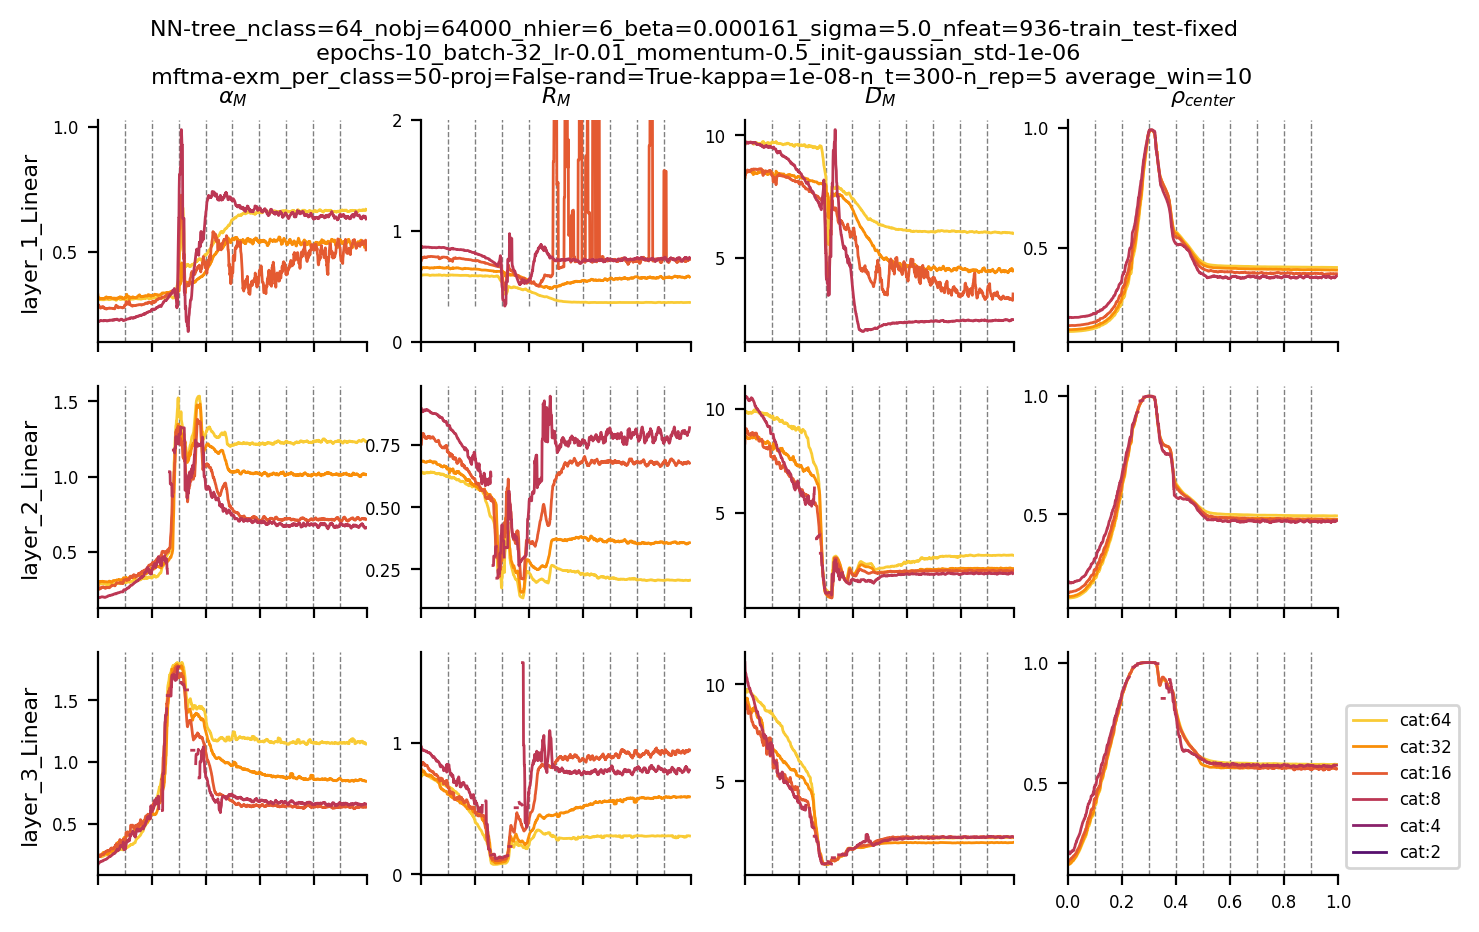

In [16]:
xmin=0
xmax=1
xtick=np.arange(0,12,2)/10
av_window=10
num_colors=accuracies.shape[1]+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','radii','dimensions','correlations']
fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
layer_num_cat=np.squeeze(np.stack([[y['n_hier_class']for y in x] for x in layer_mftma]))

corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):

    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)

ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
#ax.axes.xaxis.set_ticks(np.ceil(epoch_bar*10)/10)
#labels = ['' for item in ax.get_xticklabels()]
ax.axes.xaxis.set_ticks(xtick)
ax.axes.xaxis.set_ticklabels([])

#ax.set_xticklabels(labels)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.set_title(r'$R_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.set_ylim((0,2))

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.set_title(r'$D_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_ylim((0,2))
ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.set_title(r'$\rho_{center}$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   
################################    
# plot layer 2 results
l_num=2
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(int(np.unique(layer_num_cat[:,h]))),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_ylim((0,2))
ax=axes[(l_num-1)*len(mftma_keys)+2]

for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   

# plot layer 2 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=f"cat:{int(np.unique(layer_num_cat[:,h]))}",linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cor)[:,h],av_window),color=line_cols[h,:],label=f"cat:{int(np.unique(layer_num_cat[:,h]))}, input",linewidth=.5,linestyle='-',alpha=.4)


ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))
plt.suptitle(f"{model_identifier} \n {train_identifier} \n {analyze_identifier} average_win={av_window}",fontsize=8)


for ax in axes:
    ax.axes.xaxis.set_ticks(xtick)
    ax.axes.xaxis.set_ticklabels([])

ax.axes.xaxis.set_ticklabels(xtick)
#plt.tight_layout()
# plt.show()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
fig.savefig(os.path.join(results_dir,model_identifier+'_manifold_vals_during_training_v3_n_rep_100.pdf'),transparent=True)


# plot manifold width 

In [60]:
# # get baseline values 
# l_num=0
# layer_data=mftma_res[layer_keys[l_num]]
# layer_mftma=[x['mftma'] for x in layer_data]
# mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
# array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

# layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
# layer_width=np.squeeze(np.stack([[np.mean(np.multiply(np.asarray(y['radii_all']),np.sqrt(np.asarray(y['dimensions_all'])))) for y in x] for x in layer_mftma]))
# layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
# corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# corrected_width=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
# for idx, x in enumerate(array_corres):
#     corrected_cap[int(x)]=layer_cap[idx,:]
#     corrected_width[int(x)]=layer_width[idx,:]
#     corrected_cor[int(x)]=layer_corr[idx,:]
    
# baseline_cap=corrected_cap
# baseline_width=corrected_width
# baseline_corr=corrected_cor

In [61]:
av_window=10

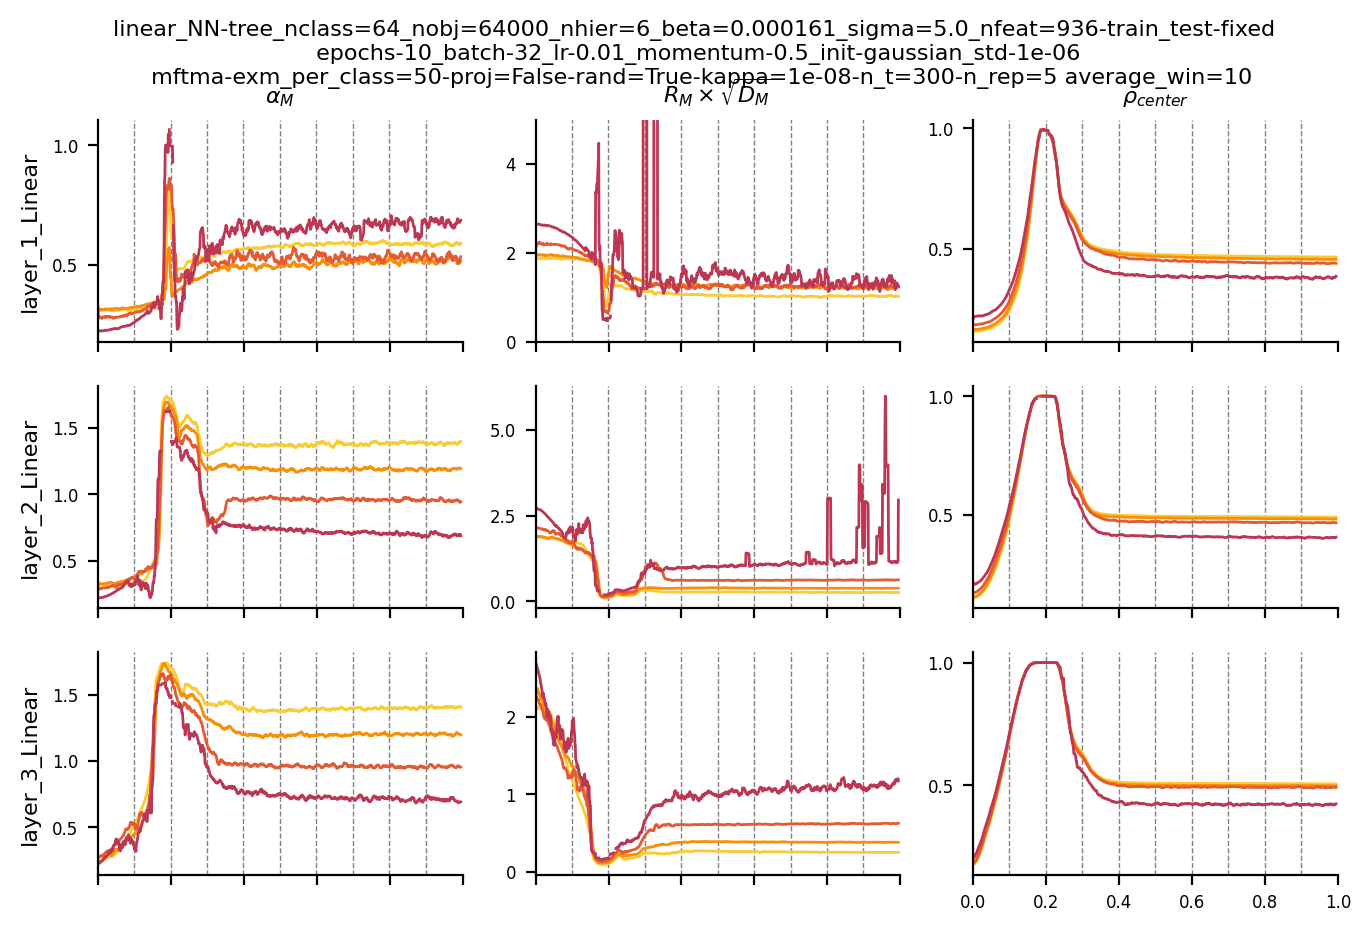

In [62]:
xmin=0
xmax=1
xtick=np.arange(0,12,2)/10
num_colors=accuracies.shape[1]+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','widths','correlations']
fig, axes = plt.subplots(3, 3, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_width=np.squeeze(np.stack([[np.mean(np.multiply(np.asarray(y['radii_all']),np.sqrt(np.asarray(y['dimensions_all'])))) for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_width=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_width[int(x)]=layer_width[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)
ax.set_title(r'$R_M \times \sqrt{D_M}$', fontsize=8)

ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_ylim((0,5))


ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_corr)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)
ax.set_title(r'$\rho_{center}$', fontsize=8)

ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   
    
# plot layer 2 results
l_num=2

layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_width=np.squeeze(np.stack([[np.mean(np.multiply(np.asarray(y['radii_all']),np.sqrt(np.asarray(y['dimensions_all'])))) for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_width=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_width[int(x)]=layer_width[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)

ax.set_ylabel(layer_keys[l_num], fontsize=8)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)

ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_corr)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   

# plot layer 2 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_width=np.squeeze(np.stack([[np.mean(np.multiply(np.asarray(y['radii_all']),np.sqrt(np.asarray(y['dimensions_all'])))) for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_width=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_width[int(x)]=layer_width[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)

ax.set_ylabel(layer_keys[l_num], fontsize=8)

ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_width)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)


ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
    #ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(baseline_corr)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=.5,linestyle='-',alpha=.4)
ax.axes.xaxis.set_ticks(np.ceil(epoch_bar*10)/10)
#ax.axes.xaxis.set_ticklabels(list(np.ceil(epoch_bar*10)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

for ax in axes:
    ax.axes.xaxis.set_ticks(xtick)
    ax.axes.xaxis.set_ticklabels([])

ax.axes.xaxis.set_ticklabels(xtick)

plt.suptitle(f"{model_identifier} \n {train_identifier} \n {analyze_identifier} average_win={av_window}",fontsize=8)
#plt.tight_layout()
# plt.show()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
fig.savefig(os.path.join(results_dir,model_identifier+'_manifold_width_during_training_v3_nrep_100.pdf'),transparent=True)


plt.show()